# Ex2 RNN

## Step 1 Prepare X, y

In [1]:
import pandas as pd
import numpy as np
from copy import copy
import torch

In [2]:
def file_to_data(filename):
    
    # read file
    raw = pd.read_csv(filename)
    
    # define columns to be extracted
    ndvi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., ndvi_mean24
    savi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., savi_mean24
    evi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., evi_mean24

    # extract each feature
    ndvi_timeseries = raw[ndvi_col]
    savi_timeseries = raw[savi_col]
    evi_timeseries = raw[evi_col]
    
    # dimension stack
    data = np.dstack([ndvi_timeseries, savi_timeseries, evi_timeseries])
    
    # get only label
    label = raw.iloc[:, -1]
    
    return data, label

def data_to_lv1_x_y(data, labels):
    
    # export all X
    # but reclass the plant cane -> 100, ratoon cane -> 200
    target = copy(labels)
    target[target > 200] = 200
    target[(target < 200) & (target > 100)] = 100
    
    return data, target

def data_to_lv2_x_y(data, target):
    
    # export X plant which labels are 100-200
    X_plant = data[(target > 100) & (target <200)]
    
    # export X ratoon which labels are >200
    X_ratoon = data[target > 200]
    
    # export y plant which labels are 100-200
    y_plant = target[(target > 100) & (target < 200)]
    
    # export y ratoon which labels are >200
    y_ratoon = target[target > 200]
    
    return X_plant, y_plant, X_ratoon, y_ratoon

def label_encode(y):
    
    target = copy(y)
    # redefine the cane plantation label to be 1 - 24
    new_y = [int(str(label)[1:]) for label in target]
    
    return np.array(new_y)

In [3]:
data, labels = file_to_data('training_data_1718.csv')

In [4]:
X, y = data_to_lv1_x_y(data, labels)

In [5]:
from sklearn.preprocessing import LabelEncoder

lu_encoder = LabelEncoder()

y = lu_encoder.fit_transform(y)

### Prepare Dataset and Dataloader

In [6]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

def Xy_dataloader(X_numpy, y_numpy, batch_size=32):
    
    X_tensor = torch.tensor(X_numpy).float()
    y_tensor = torch.tensor(y_numpy).long()
    
    dataset = TensorDataset(X_tensor, y_tensor)

    loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    
    return loader

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [8]:
train_loader = Xy_dataloader(X_train, y_train)
test_loader = Xy_dataloader(X_test, y_test)

# Level 1 Classification

In [9]:
import torch
from torch import nn

In [10]:

class RNN_lv1(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
     
        
        #[batch size, seq len, embed dim]
        out, hn= self.rnn(x)  #if no h0, all zeroes
        
        return self.fc(hn.squeeze(0))

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [20]:
model = RNN_lv1(3, 50, len(np.unique(y))).to(device)

In [21]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001) #<----changed to Adam
criterion = nn.CrossEntropyLoss() #combine sigmoid with binary cross entropy

In [22]:
def train_model(model, train_dataloader, valid_dataloader, epochs, criterion, optimizer):
    
    loss_train = []
    loss_valid = []
    
    for i in range(epochs):
        
        # ===================TRAIN ======================
        model.train()
        
        epoch_loss = 0
        
        for x, y in train_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x).squeeze(1)
            
            loss = criterion(out, y)
            
            epoch_loss += loss.item()
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_train.append(epoch_loss/len(train_dataloader))
        
        # ===================VALIDATION =================
        model.eval()
    
        epoch_loss = 0
        
        for x, y in valid_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x).squeeze(1)
            
            loss = criterion(out, y)
            
            epoch_loss += loss.item()
        
        loss_valid.append(epoch_loss/len(valid_dataloader))
        
        # ================= PRINT ===========================
        print(f'epoch {i+1}/{epochs} train loss: {loss_train[-1]} validation loss: {loss_valid[-1]}')
    
    return loss_train, loss_valid
            

In [23]:
loss_list = train_model(model, train_loader, test_loader, 100, criterion, optimizer)

epoch 1/100 train loss: 0.9713268639348077 validation loss: 0.87510910457816
epoch 2/100 train loss: 0.8686202791988427 validation loss: 0.8493289533725454
epoch 3/100 train loss: 0.8310829337607039 validation loss: 0.8208314411896319
epoch 4/100 train loss: 0.8208098479196535 validation loss: 0.8088877368564448
epoch 5/100 train loss: 0.7827566654969614 validation loss: 0.7369300397959623
epoch 6/100 train loss: 0.7400611755273021 validation loss: 0.7033549877237683
epoch 7/100 train loss: 0.6855704401824492 validation loss: 0.6811657144018441
epoch 8/100 train loss: 0.6609732724250631 validation loss: 0.6470689298200213
epoch 9/100 train loss: 0.6310610970918168 validation loss: 0.6181725849790022
epoch 10/100 train loss: 0.6225286139875439 validation loss: 0.601410455201283
epoch 11/100 train loss: 0.5908892050068429 validation loss: 0.5790988366958524
epoch 12/100 train loss: 0.5880470520004313 validation loss: 0.6145333310296713
epoch 13/100 train loss: 0.5733518319349762 validati

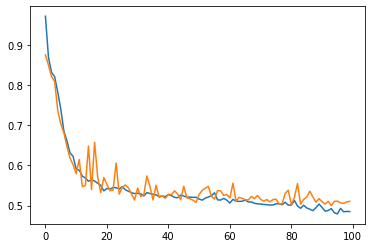

In [24]:
import matplotlib.pyplot as plt

plt.plot(loss_list[0])
plt.plot(loss_list[1])

In [25]:
def predict_model(model, test_dataloader):
    
    model.eval()
    
    pred = []
    
    for x, y in test_dataloader:
            
        x = x.to(device)
            
        out = model(x).squeeze(1).to('cpu')
    
        pred.append(torch.max(out, 1)[1].numpy())
    
    return np.concatenate(pred)

In [26]:
y_pred = predict_model(model, test_loader)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         9
          10       0.35      0.36      0.35      1347
          11       0.62      0.62      0.62      2363

    accuracy                           0.51      3858
   macro avg       0.08      0.08      0.08      3858
weighted avg       0.50      0.51      0.50      3858



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
